### This is a simple notebook to build a photometric redshift estimator using Gradient Boosting Machines.

Author: Viviana Acquaviva
    
License: TBD

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)


font = {'size'   : 16}
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
#matplotlib.rcParams.update({'figure.autolayout': True})
matplotlib.rcParams['figure.dpi'] = 300

In [3]:
from sklearn import metrics
from sklearn.model_selection import cross_validate, KFold, cross_val_predict, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor

### We can read the data set with the selections applied in the previous notebook.

In [4]:
sel_features = pd.read_csv('sel_features.csv', sep = '\t')

In [6]:
sel_target = pd.read_csv('sel_target.csv')

In [7]:
sel_features.shape

(6307, 6)

In [8]:
sel_target.values.ravel() #changes shape to 1d row-like array

array([1.0034, 0.9023, 0.4242, ..., 0.3703, 0.371 , 0.7333])

### Our final algorithm will be Gradient Boosting! 

There are several implementations; one of the most popular ones is XGBoost, which is significanty faster than sklearn's GBM - the Gradient Boosting Machine.

In [9]:
from sklearn.ensemble import GradientBoostingRegressor

The parameters depend on the particular implementation.

In the sklearn formulation, the parameters of each tree are essentially the same we have for Random Forests; additionally we have the "learning_rate" parameter, which dictates how much each tree contribute to the final estimator, and the "subsample" parameters, which allows one to use a < 1.0 fraction of samples.


We can check how this works with a weak learner (a 3-split decision tree) on our toy data set (the black points).

R2 score:  0.721
R2 score:  -28.773
R2 score:  -11.218
R2 score:  -6.118
R2 score:  0.005
R2 score:  0.998


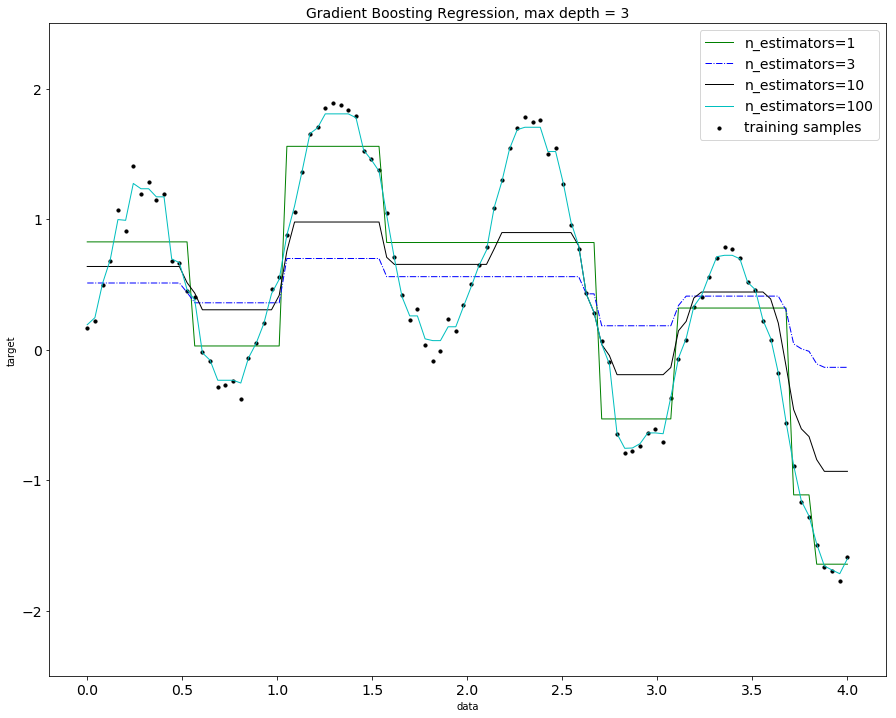

In [10]:
# Create the dataset
plt.figure(figsize=(15,12))

rng = np.random.RandomState(1)
X = np.linspace(0, 4, 100)[:, np.newaxis]
y = np.sin(X).ravel() + np.sin(6 * X).ravel() + rng.normal(0, 0.1, X.shape[0])

weakl = DecisionTreeRegressor(max_depth=3)

# Fit regression model
regr_1 = weakl
""
regr_2 = GradientBoostingRegressor(max_depth=3,
                          n_estimators=2, random_state=rng)

regr_3 = GradientBoostingRegressor(max_depth=3,
                          n_estimators=3, random_state=rng)

regr_4 = GradientBoostingRegressor(max_depth=3,
                          n_estimators=4, random_state=rng)

regr_10 = GradientBoostingRegressor(max_depth=3,
                          n_estimators=10, random_state=rng)

regr_100 = GradientBoostingRegressor(max_depth=3,
                          n_estimators=100, random_state=rng)


regr_1.fit(X, y)
regr_2.fit(X, y)
regr_3.fit(X, y)
regr_4.fit(X, y)
regr_10.fit(X, y)
regr_100.fit(X, y)

# Predict
y_1 = regr_1.predict(X)
y_2 = regr_2.predict(X)
y_3 = regr_3.predict(X)
y_4 = regr_4.predict(X)
y_10 = regr_10.predict(X)
y_100 = regr_100.predict(X)

for yp in [y_1,y_2,y_3,y_4,y_10, y_100]:
    print('R2 score: ', np.round(metrics.r2_score(yp,y),3))

# Plot the results

plt.scatter(X, y, c="k", s=10,label="training samples")
plt.plot(X, y_1, "-g", label="n_estimators=1", linewidth=1)
#plt.plot(X, y_2, "--r", label="n_estimators=2", linewidth=1)
plt.plot(X, y_3, "-.b", label="n_estimators=3", linewidth=1)
#plt.plot(X, y_4, ":m", label="n_estimators=4", linewidth=1)
plt.plot(X, y_10, "-k", label="n_estimators=10", linewidth=1)
plt.plot(X, y_100, "-c", label="n_estimators=100", linewidth=1)
plt.xlabel("data")
plt.ylabel("target")
plt.ylim(-2.5,2.5)
plt.title("Gradient Boosting Regression, max depth = 3", fontsize = 14)
plt.legend(fontsize=14, loc = 'upper right');
#plt.tight_layout()
#plt.savefig("GradBoost_3.png")

### We can see that the boosting process works (makes the regressor more accurate) even with a simple base learner (a 3-split decision tree).

### We can compare with XGBoost (the non-sklearn version).

Sometimes knowns as "regularized" GBM, more robust to overfitting.

Has more flexibility in defining weak learners, and objective function.


In [11]:
import xgboost as xgb

Medium article explaining XGBoost: [here](https://towardsdatascience.com/a-beginners-guide-to-xgboost-87f5d4c30ed7)

We can establish our benchmark:

In [12]:
model = xgb.XGBRegressor(objective ='reg:squarederror') #This is to avoid deprecation error

ypred = cross_val_predict(model, sel_features,sel_target.values.ravel(), cv = KFold(n_splits=5, shuffle=True, random_state=10))

Text(0, 0.5, 'Predicted redshifts')

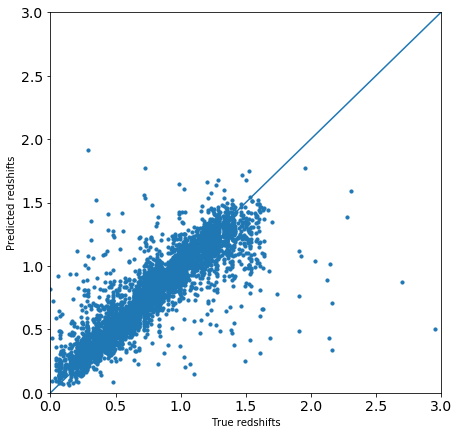

In [13]:
plt.figure(figsize=(7,7))
plt.scatter(sel_target,ypred, s =10)
plt.plot(np.linspace(0,3,100),np.linspace(0,3,100))
plt.ylim(0,3)
plt.xlim(0,3)
plt.xlabel('True redshifts')
plt.ylabel('Predicted redshifts')

Calculate outlier fraction and NMAD

In [14]:
print(len(np.where(np.abs(sel_target.values.ravel()-ypred)>0.15*(1+sel_target.values.ravel()))[0])/len(sel_target.values.ravel()))

print(1.48*np.median(np.abs(sel_target.values.ravel()-ypred)/(1 + sel_target.values.ravel())))

0.0646900269541779
0.05189034300694086


Let's see what happens with optimization.

In [15]:
parameters = {'max_depth':[3,6,None], 'n_estimators':[100,200, 500], 'learning_rate': [0.1, 0.3,0.5,1.0]}
nmodels = np.product([len(el) for el in parameters.values()])
model = GridSearchCV(xgb.XGBRegressor(objective ='reg:squarederror'), parameters, cv = KFold(n_splits=5, shuffle=True), \
                     verbose = 2, n_jobs = 4, return_train_score=True)
model.fit(sel_features,sel_target.values.ravel())

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   32.4s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:  3.2min finished


Best params, best score: 0.7214 {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 500}


In [16]:
scores = pd.DataFrame(model.cv_results_)
scoresCV = scores[['params','mean_test_score','std_test_score','mean_train_score','mean_fit_time']].sort_values(by = 'mean_test_score', \
                                                    ascending = False)
scoresCV

,params,mean_test_score,std_test_score,mean_train_score,mean_fit_time
5,"{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 500}",0.721435,0.044634,0.991136,9.959863
8,"{'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 500}",0.721435,0.044634,0.991136,10.015363
4,"{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}",0.718630,0.042643,0.966883,4.009973
7,"{'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 200}",0.718630,0.042643,0.966883,4.084046
13,"{'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 200}",0.713285,0.038640,0.994045,3.953346
16,"{'learning_rate': 0.3, 'max_depth': None, 'n_estimators': 200}",0.713285,0.038640,0.994045,3.901839
14,"{'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 500}",0.713101,0.037832,0.999600,9.635851
17,"{'learning_rate': 0.3, 'max_depth': None, 'n_estimators': 500}",0.713101,0.037832,0.999600,9.921542
15,"{'learning_rate': 0.3, 'max_depth': None, 'n_estimators': 100}",0.712751,0.041782,0.980170,1.969269
12,"{'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 100}",0.712751,0.041782,0.980170,2.129830


In [30]:
bm = model.best_estimator_

In [31]:
bm.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 500,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [32]:
scores_bm = cross_validate(bm, sel_features, sel_target.values.ravel(), cv = KFold(n_splits=5, shuffle = True, random_state=10),return_train_score=True)

In [33]:
scores_bm

{'fit_time': array([2.15642905, 2.20047188, 2.19968677, 2.29713583, 2.29789901]),
 'score_time': array([0.00546837, 0.00442791, 0.00580311, 0.00550818, 0.00443196]),
 'test_score': array([0.72357841, 0.69481443, 0.55525119, 0.81735111, 0.84788883]),
 'train_score': array([0.99139141, 0.99115892, 0.99175911, 0.99133568, 0.99117177])}

In [21]:
scores_bm['test_score'].mean()

0.7277767940900552

In [34]:
y_pred_bm = cross_val_predict(bm, sel_features, sel_target.values.ravel(), cv = KFold(n_splits=5, shuffle = True, random_state=10))

Look for outlier fraction and NMAD:

In [35]:
print(len(np.where(np.abs(sel_target.values.ravel()-y_pred_bm)>0.15*(1+sel_target.values.ravel()))[0])/len(sel_target.values.ravel()))

print(1.48*np.median(np.abs(sel_target.values.ravel()-y_pred_bm)/(1 + sel_target.values.ravel())))

0.05660377358490566
0.04403115083797733


Text(0, 0.5, 'Predicted redshifts')

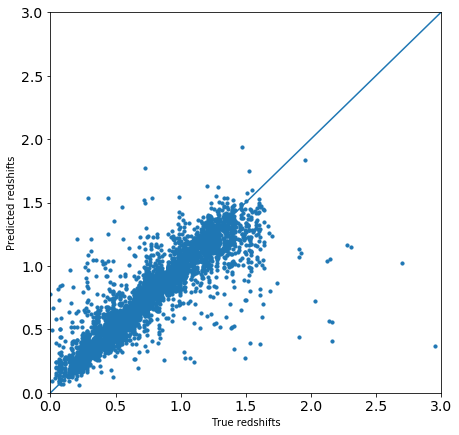

In [36]:
plt.figure(figsize=(7,7))
plt.scatter(sel_target,y_pred_bm, s =10)
plt.plot(np.linspace(0,3,100),np.linspace(0,3,100))
plt.ylim(0,3)
plt.xlim(0,3)
plt.xlabel('True redshifts')
plt.ylabel('Predicted redshifts')

### Conclusion: the winner is....